In [1]:
import numpy as np
from tqdm import tqdm
from math import sqrt,exp
import matplotlib
from matplotlib import pyplot as plt
from multiprocessing import Pool
from itertools import product
from qutip import *
font = {'size'   : 17}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 7, 4
# plt.rcParams['figure.dpi'] = 60
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True

# Hubbard Dimer to Hubbard Model

## Steps

- Define the lattice of parent Hubbard model: $\left\{k, \xi_k\right\}$
- Obtain $t, U$ for $\tilde H$. Stored in the variables ```tp``` and ```Up``` here. Also define the dimer parameters ```td, Ud```
- Choose test Hamiltonian from which to calculate groundstate wavefunction. This model should be close to $\tilde H$, so it will be defined by the parameters ```tp, Up```
- Calculate groundstate $|\tilde \Phi_0\rangle$ and energy of ground state $E_0$, using exact diagonalization.
- Define the orthonormal basis $\{|n\rangle\}$. The dimer part (defined by ```td, Ud```) gives the set of eigenvalues $E_n$
- Calculate $C^i_n = \langle n |c^\dagger_{0 \sigma}|\tilde \Phi_0\rangle $, hence $\lambda_n$, and the energy cost $\Delta_n = E_n - E_0$.
- With $\lambda_n$ and $\Delta_n$ at hand, calculate spectral function using the formula: 
$$
A(k, \omega) = \frac{2}{N}\sum_n \left[ \lambda_n \delta(\omega - \Delta_n) + \overline\lambda_n \delta(\omega + \Delta_n)\right]\\
\lambda_n = |C^0_{n}|^2 + \frac{\xi_{\vec{k}}}{w}{C^0_{n}}^* C^1_{n}, ~~~\overline\lambda_n = |\overline C^0_{n}|^2 + \frac{\xi_{\vec{k}}}{w}{\overline C^0_{n}}^* \overline C^1_{n}
$$


## Parent Hubbard Model

$$
D = \text{ dimension }\\
N = \text{number of sites}\\
w = \text{coordination number}\\
\{a_i k^n_i\} = \frac{2\pi n}{N}\\
\xi_{\vec k} = \sum_{i=1}^D 2\cos(a_i k_i) \text{  for hypercubic lattice}
$$ 

In [2]:
def define_Hub(N=3, w=2, dim=1, a=1):
    k_arr = list(product(*[2 * np.pi * np.arange(N) / (N * a) for i in range(dim)]))
    if dim == 1:
        k_arr = [k[0] for k in k_arr]
    xi = []
    for k in k_arr:
        xi_k = 0
        k = [k] if dim == 1 else k
        for i in range(dim):
            xi_k += 2*np.cos(k[i]*a)
        xi.append(xi_k)
    xi = np.array(xi)
    return k_arr, xi

## Test Hamiltonian
$N_k = \sum_k$1

$H = \sum_{k\sigma}\epsilon_k \tau_{k\sigma} + U^D\left(\tau_{0\uparrow}\tau_{0\downarrow} + \tau_{1\uparrow}\tau_{1\downarrow}\right) - t^D\sum_\sigma\left(c^\dagger_{0\sigma}c_{1\sigma} + \text{h.c.}\right) - \frac{1}{\sqrt N_k}t^D\sum_{\sigma, k=k_1}^{k_{N-2}}\left(c^\dagger_{0\sigma}c_{k\sigma} + c^\dagger_{1\sigma}c_{k\sigma} + \text{h.c.}\right)$

Notation for Hamiltonian: $k_1 \uparrow k_1 \downarrow, k_2 \uparrow, ... k_N \uparrow k_N \downarrow$

In [3]:
def ham_u(U, t, Ek):
    Nk = len(Ek)
    tau = create(2)*destroy(2) - 0.5
    H_u = U*(tensor([tau, tau] + [identity(2)]*2*(1 + Nk)) + tensor([identity(2)]*2 + [tau, tau]+ [identity(2)]*2*Nk))
    return H_u


def ham_t_1(U, t, Ek):
    Nk = len(Ek)
    tau = create(2)*destroy(2) - 0.5
    H_t_1_up = tensor([create(2), identity(2), destroy(2), identity(2)] + [identity(2)]*2*Nk)
    H_t_1_dn = tensor([identity(2), create(2), identity(2), destroy(2)] + [identity(2)]*2*Nk)
    H_t_1 = -t*((H_t_1_up + H_t_1_dn) + (H_t_1_up + H_t_1_dn).dag())
    return H_t_1


def ham_t_2(U, t, Ek):
    Nk = len(Ek)
    tau = create(2)*destroy(2) - 0.5
    H_t_2_up = 0
    H_t_2_dn = 0
    for k in range(len(Ek)):
        H_t_2_up += tensor([create(2), identity(2)] + [identity(2)]*2*(1+k) + [destroy(2), identity(2)] + [identity(2)]*2*(len(Ek)- k - 1))
        H_t_2_dn += tensor([identity(2), create(2)] + [identity(2)]*2*(1+k) + [identity(2), destroy(2)] + [identity(2)]*2*(len(Ek)- k - 1))
    H_t_2 = (-t/sqrt(Nk))*((H_t_2_up + H_t_2_dn) + (H_t_2_up + H_t_2_dn).dag())
    return H_t_2


def ham_k(U, t, Ek):
    Nk = len(Ek)
    tau = create(2)*destroy(2) - 0.5
    H_k_up = 0
    H_k_dn = 0
    for k in range(len(Ek)):
        H_k_up += Ek[k]*(tensor([identity(2)]*2*(2+k) + [tau, identity(2)] + [identity(2)]*2*(len(Ek)- k - 1)))
        H_k_dn += Ek[k]*(tensor([identity(2)]*2*(2+k) + [identity(2), tau] + [identity(2)]*2*(len(Ek)- k - 1)))
    H_k = H_k_up + H_k_dn + (H_k_up + H_k_dn).dag()
    return H_k

def get_ham_dim_bath(U, t, Ek):
    H_k = ham_k(U, t, Ek)
    H_u = ham_u(U, t, Ek)
    H_t_1 = ham_t_1(U, t, Ek)
    H_t_2 = ham_t_2(U, t, Ek)
    return H_k + H_u + H_t_1 + H_t_2

## Ground state wavefunction (and eigenvalue)

In [4]:
def gstate(H):
    E0, X0 = H.groundstate()
    return E0, X0

## Orthonormal basis

In [5]:
def get_n_En(Ud, td, Ek_bath):
    H_k = ham_k(Ud, td, Ek_bath)
    H_u = ham_u(Ud, td, Ek_bath)
    H_t_1 = ham_t_1(Ud, td, Ek_bath)
    H_t_2 = ham_t_2(Ud, td, Ek_bath)
    dimer_bath_discon = H_k + H_u + H_t_1
    E, Xn = dimer_bath_discon.eigenstates()
    only_dimer =  ham_u(Ud, td, []) + ham_t_1(Ud, td, [])
    En = only_dimer.eigenenergies()
    return En, Xn

## Coefficients

In [6]:
def get_lambda_delta(En, Xn, E0, X0, xi_k, w):
    N = len(X0.dims[0])
    cdag0 = tensor([create(2), identity(2)] + [identity(2)]*(N-2))
    cdag1 = tensor([identity(2)]*2 + [create(2), identity(2)] + [identity(2)]*(N-4))
    c0 = tensor([destroy(2), identity(2)] + [identity(2)]*(N-2))
    c1 = tensor([identity(2)]*2 + [destroy(2), identity(2)] + [identity(2)]*(N-4))
    delta_n = [E_n - E0 for E_n in En]
    C0 = np.array([(X_n.dag() * cdag0 * X0)[0][0][0] for X_n in Xn])
    C1 = np.array([(X_n.dag() * cdag1 * X0)[0][0][0] for X_n in Xn])
    C0_ = np.array([(X_n.dag() * c0 * X0)[0][0][0] for X_n in Xn])
    C1_ = np.array([(X_n.dag() * c1 * X0)[0][0][0] for X_n in Xn])
    lambda_n = np.real(C0*C0.conjugate() + (xi_k/w)*C0.conjugate()*C1)
    lambda_n_ = np.real(C0_*C0_.conjugate() + (xi_k/w)*C0_.conjugate()*C1_)
    return lambda_n, lambda_n_, delta_n

## Spectral function $A(k,\omega)$

In [7]:
def spec_func_k(N, delta_n, lambda_n, lambda_n_, w_range):

    def gauss(x):
        eta = 0.4
        return exp(-(x/eta)**2)/(eta*sqrt(np.pi))


    Ak = []
    for w in w_range:
        Ak.append(sum([lambdan * gauss(w - deltan) + lambdan_ * gauss(w + deltan) for deltan,lambdan,lambdan_ in zip(delta_n, lambda_n, lambda_n_)])*2/N)
    return np.array(Ak)

In [8]:
def get_max(A, w_range):
    w_max = []
    A_max = []
    for i in range(1, len(A)-1):
        if A[i-1] < A[i] and A[i+1] < A[i]:
            print (w_range[i])
            A_max.append(A[i])
            w_max.append(w_range[i])
    return w_max, A_max

## Manager

In [9]:
N=4
w=2
dim=1
a=1
k_arr, xi = define_Hub(N, w, dim, a)
xi_k = xi[1]
fig, ax = plt.subplots(4, figsize=(6,20))
i = 0
for U in [0.001, 0.01, 0.1, 0.5]:
    t = 0.1
    Ud = N * U
    td = N * t
    Up = 2 * Ud / N
    tp = 2 * td / (N * w)
    Nk = 2
    k_bath = 2*np.pi*np.arange(Nk)/((Nk)*a)
    Ek_bath = -2*td*np.cos(k_bath*a)
    H_dim_bath = get_ham_dim_bath(Up, tp, Ek_bath)
    E0, X0 = gstate(H_dim_bath)
    En, Xn = get_n_En(Ud, td, Ek_bath)
    print ("ED done")
    lambda_n, lambda_n_, delta_n = get_lambda_delta(En, Xn, E0, X0, xi_k, w)
    w_range = np.arange(-5, 5, 0.001)
    Ak = spec_func_k(N, delta_n, lambda_n, lambda_n_, w_range)
    ax[i].plot(w_range, Ak, label=r"$U/t = {}$".format(U/t))
    ax[i].set_ylabel(r"$A(k=0,\omega)$")
    ax[i].legend()
    i += 1

plt.suptitle(r"$N_k = {}$".format(Nk), y=0.9)
plt.show()

ED done
ED done


KeyboardInterrupt: 

## Spectral function of Dimer in Bath from ED

### Broadening with no $\omega-$dependence

In [ ]:
def rho_at_w(args):
    (En, Xn), Xgs, w, t = args
    # eta = 2*t**2/sqrt(t**2 + sqrt(U)*w**2/sqrt(t)) 
    eta = 2*t**2/sqrt(t**2 + U**2/16)
    N = len(Xgs.dims[0])
    Z = len(X0)
    Egs = E[0]
    c0_up = tensor([destroy(2), identity(2)] + [identity(2)]*(N-2))
    C1 = Xgs.dag()*c0_up*Xn
    C1_sq = np.real((C1*C1.dag())[0][0][0])
    C2 = Xn.dag()*c0_up*Xgs
    C2_sq = np.real((C2*C2.dag())[0][0][0])
    x1 = w + Egs - En
    x2 = w + En - Egs
    return (C1_sq * exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z

for U in [0, 0.02, 0.03, 0.05, 0.08, 0.2]:
    t = 0.01
    Nk = 2
    a = 1
    k_bath = 2*np.pi*np.arange(Nk)/((Nk)*a)
    Ek_bath = -2*t*np.cos(k_bath*a)
    H_dim_bath = get_ham_dim_bath(U, t, Ek_bath)
    E, X = H_dim_bath.eigenstates()
    print ("ED Done")
    E0 = E[np.where(E == min(E))]
    X0 = X[np.where(E == min(E))]
    Z = len(E0)
    exc = zip(E[1:], X[1:])
    gs = X0
    rho = []
    w_range = np.linspace(-10, 10, 200, endpoint=True)*t
    for w in tqdm(w_range):
        rho_w = sum(Pool(processes=5).map(rho_at_w, product(zip(E[1:], X[1:]), X0, [w], [t])))
        rho.append(rho_w)

    plt.plot(w_range, rho)
    plt.ylabel(r"$A_{00}(\omega)$")
    # for x in np.linspace(-12, 12, 10, endpoint=True)*t:
    #     plt.axvline(x, 0, 1, ls="--")
    plt.title(r"$U={}, t={}$".format(U, t))
    plt.show()

### Broadening with $\omega-$dependence

ED Done
100%|██████████| 200/200 [00:32<00:00,  6.21it/s]


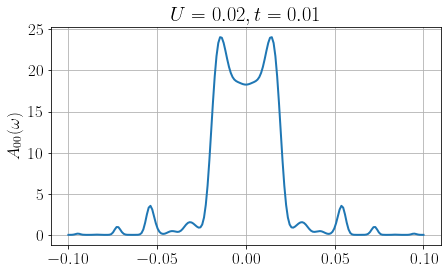

ED Done
100%|██████████| 200/200 [00:33<00:00,  5.96it/s]


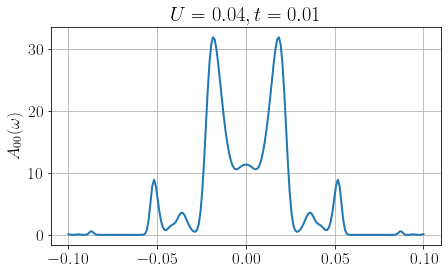

ED Done
100%|██████████| 200/200 [00:43<00:00,  4.56it/s]


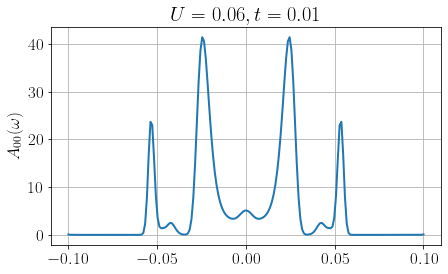

In [10]:
def rho_at_w(args):
    (En, Xn), Xgs, w, t = args
    eta = 2*t**2/sqrt(t**2 + sqrt(U)*w**2/sqrt(t)) 
    # eta = 2*t**2/sqrt(t**2 + U**2/16)
    N = len(Xgs.dims[0])
    Z = len(X0)
    Egs = E[0]
    c0_up = tensor([destroy(2), identity(2)] + [identity(2)]*(N-2))
    C1 = Xgs.dag()*c0_up*Xn
    C1_sq = np.real((C1*C1.dag())[0][0][0])
    C2 = Xn.dag()*c0_up*Xgs
    C2_sq = np.real((C2*C2.dag())[0][0][0])
    x1 = w + Egs - En
    x2 = w + En - Egs
    return (C1_sq * exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z

for U in [0.02, 0.04, 0.06]:
    t = 0.01
    Nk = 2
    a = 1
    k_bath = 2*np.pi*np.arange(Nk)/((Nk)*a)
    Ek_bath = -2*t*np.cos(k_bath*a)
    H_dim_bath = get_ham_dim_bath(U, t, Ek_bath)
    E, X = H_dim_bath.eigenstates()
    print ("ED Done")
    E0 = E[np.where(E == min(E))]
    X0 = X[np.where(E == min(E))]
    Z = len(E0)
    exc = zip(E[1:], X[1:])
    gs = X0
    rho = []
    w_range = np.linspace(-10, 10, 200, endpoint=True)*t
    for w in tqdm(w_range):
        rho_w = sum(Pool(processes=5).map(rho_at_w, product(zip(E[1:], X[1:]), X0, [w], [t])))
        rho.append(rho_w)

    plt.plot(w_range, rho)
    plt.ylabel(r"$A_{00}(\omega)$")
    plt.title(r"$U={}, t={}$".format(U, t))
    plt.show()

# Comparison with 1D chain $(N > 2)$

In [11]:
def hopping(t, N):
    H_hop = 0
    for i in range(N):
        for spin in ['u', 'd']:
            if spin == 'u':
                op = [create(2), identity(2)]
            else:
                op = [identity(2), destroy(2)]
            pre = [identity(2)]*2*i
            site_i = op
            if i == N-1:
                pre  = op + pre[2:]
                site_j = []
                post = []
            else:
                site_j = op
                post = [identity(2)]*2*(N - i - 2)
            H_hop += tensor(pre+site_i+site_j+post)
    H_hop *= -t
    return H_hop + H_hop.dag()


def onsite(U, N):
    H_ons = 0
    for i in range(N):
        pre = [identity(2)]*2*i
        site_i = [create(2)*destroy(2) - 0.5, create(2)*destroy(2) - 0.5]
        post = [identity(2)]*2*(N - i - 1)
        H_ons += tensor(pre+site_i+post)
    return U*H_ons

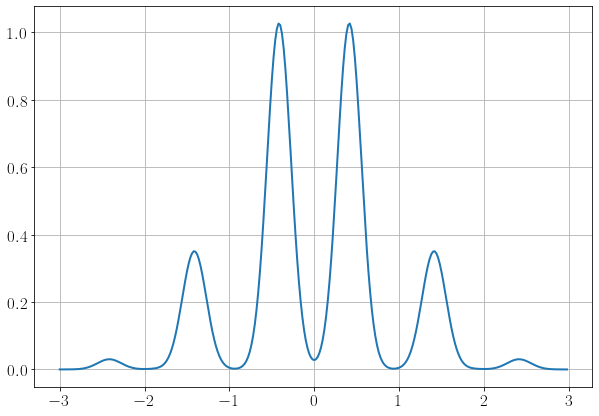

In [13]:
def rho_at_w(args):
    eta = 0.2
    (En, Xn), Xgs, w = args
    Z = len(X0)
    Egs = E[0]
    c0_up = tensor([destroy(2), identity(2)] + [identity(2)]*2*(N-1))
    C1 = Xgs.dag()*c0_up*Xn
    C1_sq = np.real((C1*C1.dag())[0][0][0])
    C2 = Xn.dag()*c0_up*Xgs
    C2_sq = np.real((C2*C2.dag())[0][0][0])
    x1=w + Egs - En
    x2=w + En - Egs
    return (C1_sq * exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z

    
t = 0.5
U = 0.1
delta = sqrt(U**2 + 16*t**2)
ham = 0
N = 4
ham += hopping(t, N)
ham += onsite(U, N)
E, X = ham.eigenstates()
E0 = E[np.where(E == min(E))]
X0 = X[np.where(E == min(E))]
Z = len(E0)
exc = zip(E[1:], X[1:])
gs = X0
rho = []
w_range = np.arange(-3, 3, 0.02)
for w in w_range:
    rho_w = sum(Pool(processes=8).map(rho_at_w, product(zip(E[1:], X[1:]), X0, [w])))
    rho.append(rho_w)

plt.rcParams["figure.figsize"]= 10, 7
plt.plot(w_range, rho)
plt.show()